In [7]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import zipfile
import pickle

# Obter dados

## Baixar

In [8]:
# # URL do arquivo no Google Drive
#import gdown
# url = "https://drive.google.com/uc?id=1S9GGQljPv9Rp_I4awW8g520aJb2JeBli"

# # Nome do arquivo a ser salvo
# output = "dataset.zip"

# # Baixar o arquivo
# gdown.download(url, output, quiet=False)

# # Verificar se o arquivo é ZIP e descompactar
# if zipfile.is_zipfile(output):
#     with zipfile.ZipFile(output, 'r') as zip_ref:
#         # Criar um diretório para extrair os arquivos
#         extract_path = "extracted_data"
#         os.makedirs(extract_path, exist_ok=True)
#         zip_ref.extractall(extract_path)
#         print(f"Arquivos extraídos para: {extract_path}")
# else:
#     print("O arquivo baixado não é um arquivo ZIP.")

In [9]:
import os
import pandas as pd

# Caminho para a pasta de imagens
# IMAGES_PATH = '/teamspace/studios/this_studio/unsupervised_disaster/extracted_data/images'
IMAGES_PATH = '/teamspace/studios/this_studio/images'


# Função para processar os nomes das imagens
def process_image_metadata(images_folder):
    data = []

    # Iterar sobre todos os arquivos na pasta de imagens
    for filename in os.listdir(images_folder):
        if filename.endswith('.png') or filename.endswith('.jpg'):
            # Separar informações do nome da imagem
            parts = filename.split('_')
            disaster_type = parts[0]  # Exemplo: 'guatemala-volcano' ou 'socal-fire'
            disaster_status = "Com desastre" if "post" in parts[-2] else "Sem desastre"
            image_reference = os.path.splitext(filename)[0]  # Nome sem extensão

            # Adicionar informações à lista
            data.append({
                "Image Reference": image_reference,
                "Image Name": filename,
                "Disaster Type": disaster_type,
                "Disaster Status": disaster_status
            })

    # Criar DataFrame
    df = pd.DataFrame(data)
    return df

# Processar imagens e criar DataFrame
image_metadata_df = process_image_metadata(IMAGES_PATH)

In [10]:
image_metadata_df

,Image Reference,Image Name,Disaster Type,Disaster Status
0,guatemala-volcano_00000000_post_disaster,guatemala-volcano_00000000_post_disaster.png,guatemala-volcano,Com desastre
1,guatemala-volcano_00000000_pre_disaster,guatemala-volcano_00000000_pre_disaster.png,guatemala-volcano,Sem desastre
2,guatemala-volcano_00000001_post_disaster,guatemala-volcano_00000001_post_disaster.png,guatemala-volcano,Com desastre
3,guatemala-volcano_00000001_pre_disaster,guatemala-volcano_00000001_pre_disaster.png,guatemala-volcano,Sem desastre
4,guatemala-volcano_00000002_post_disaster,guatemala-volcano_00000002_post_disaster.png,guatemala-volcano,Com desastre
...,...,...,...,...
5593,socal-fire_00001398_pre_disaster,socal-fire_00001398_pre_disaster.png,socal-fire,Sem desastre
5594,socal-fire_00001399_post_disaster,socal-fire_00001399_post_disaster.png,socal-fire,Com desastre
5595,socal-fire_00001399_pre_disaster,socal-fire_00001399_pre_disaster.png,socal-fire,Sem desastre
5596,socal-fire_00001402_post_disaster,socal-fire_00001402_post_disaster.png,socal-fire,Com desastre


# EDA

In [11]:
# Contagem por tipo de desastre natural
disaster_counts = image_metadata_df['Disaster Type'].value_counts()


# Contagem de imagens com desastre e sem desastre (total e por tipo de desastre)
status_counts_total = image_metadata_df['Disaster Status'].value_counts()
status_counts_by_disaster = image_metadata_df.groupby(['Disaster Type', 'Disaster Status']).size()

# Exibir os resultados
print("Contagem por tipo de desastre natural:")
print(disaster_counts)

print("\nContagem total de imagens com desastre e sem desastre:")
print(status_counts_total)

print("\nContagem de imagens com desastre e sem desastre por tipo de desastre:")
print(status_counts_by_disaster)

Contagem por tipo de desastre natural:
Disaster Type
socal-fire             1646
hurricane-michael       686
hurricane-florence      638
hurricane-harvey        638
midwest-flooding        558
hurricane-matthew       476
santa-rosa-wildfire     452
mexico-earthquake       242
palu-tsunami            226
guatemala-volcano        36
Name: count, dtype: int64

Contagem total de imagens com desastre e sem desastre:
Disaster Status
Com desastre    2799
Sem desastre    2799
Name: count, dtype: int64

Contagem de imagens com desastre e sem desastre por tipo de desastre:
Disaster Type        Disaster Status
guatemala-volcano    Com desastre        18
                     Sem desastre        18
hurricane-florence   Com desastre       319
                     Sem desastre       319
hurricane-harvey     Com desastre       319
                     Sem desastre       319
hurricane-matthew    Com desastre       238
                     Sem desastre       238
hurricane-michael    Com desastre       3

In [12]:
disasters = image_metadata_df[image_metadata_df['Disaster Status'] == 'Com desastre']
disaster_counts = disasters['Disaster Type'].value_counts()

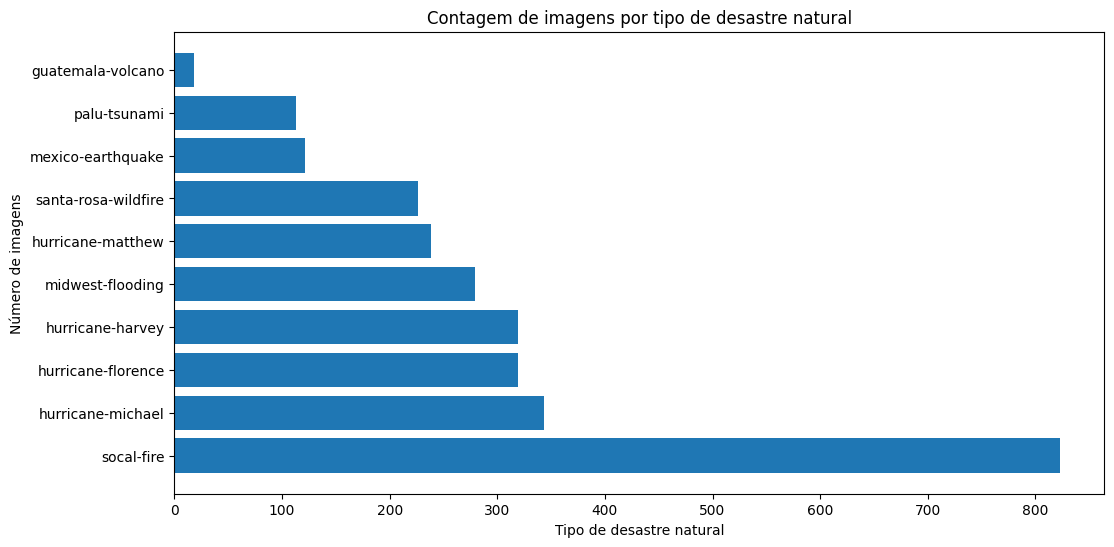

In [13]:
plt.figure(figsize=(12, 6))
plt.barh(disaster_counts.index, disaster_counts.values)
plt.xlabel('Tipo de desastre natural')
plt.ylabel('Número de imagens')
plt.title('Contagem de imagens por tipo de desastre natural')
plt.show()

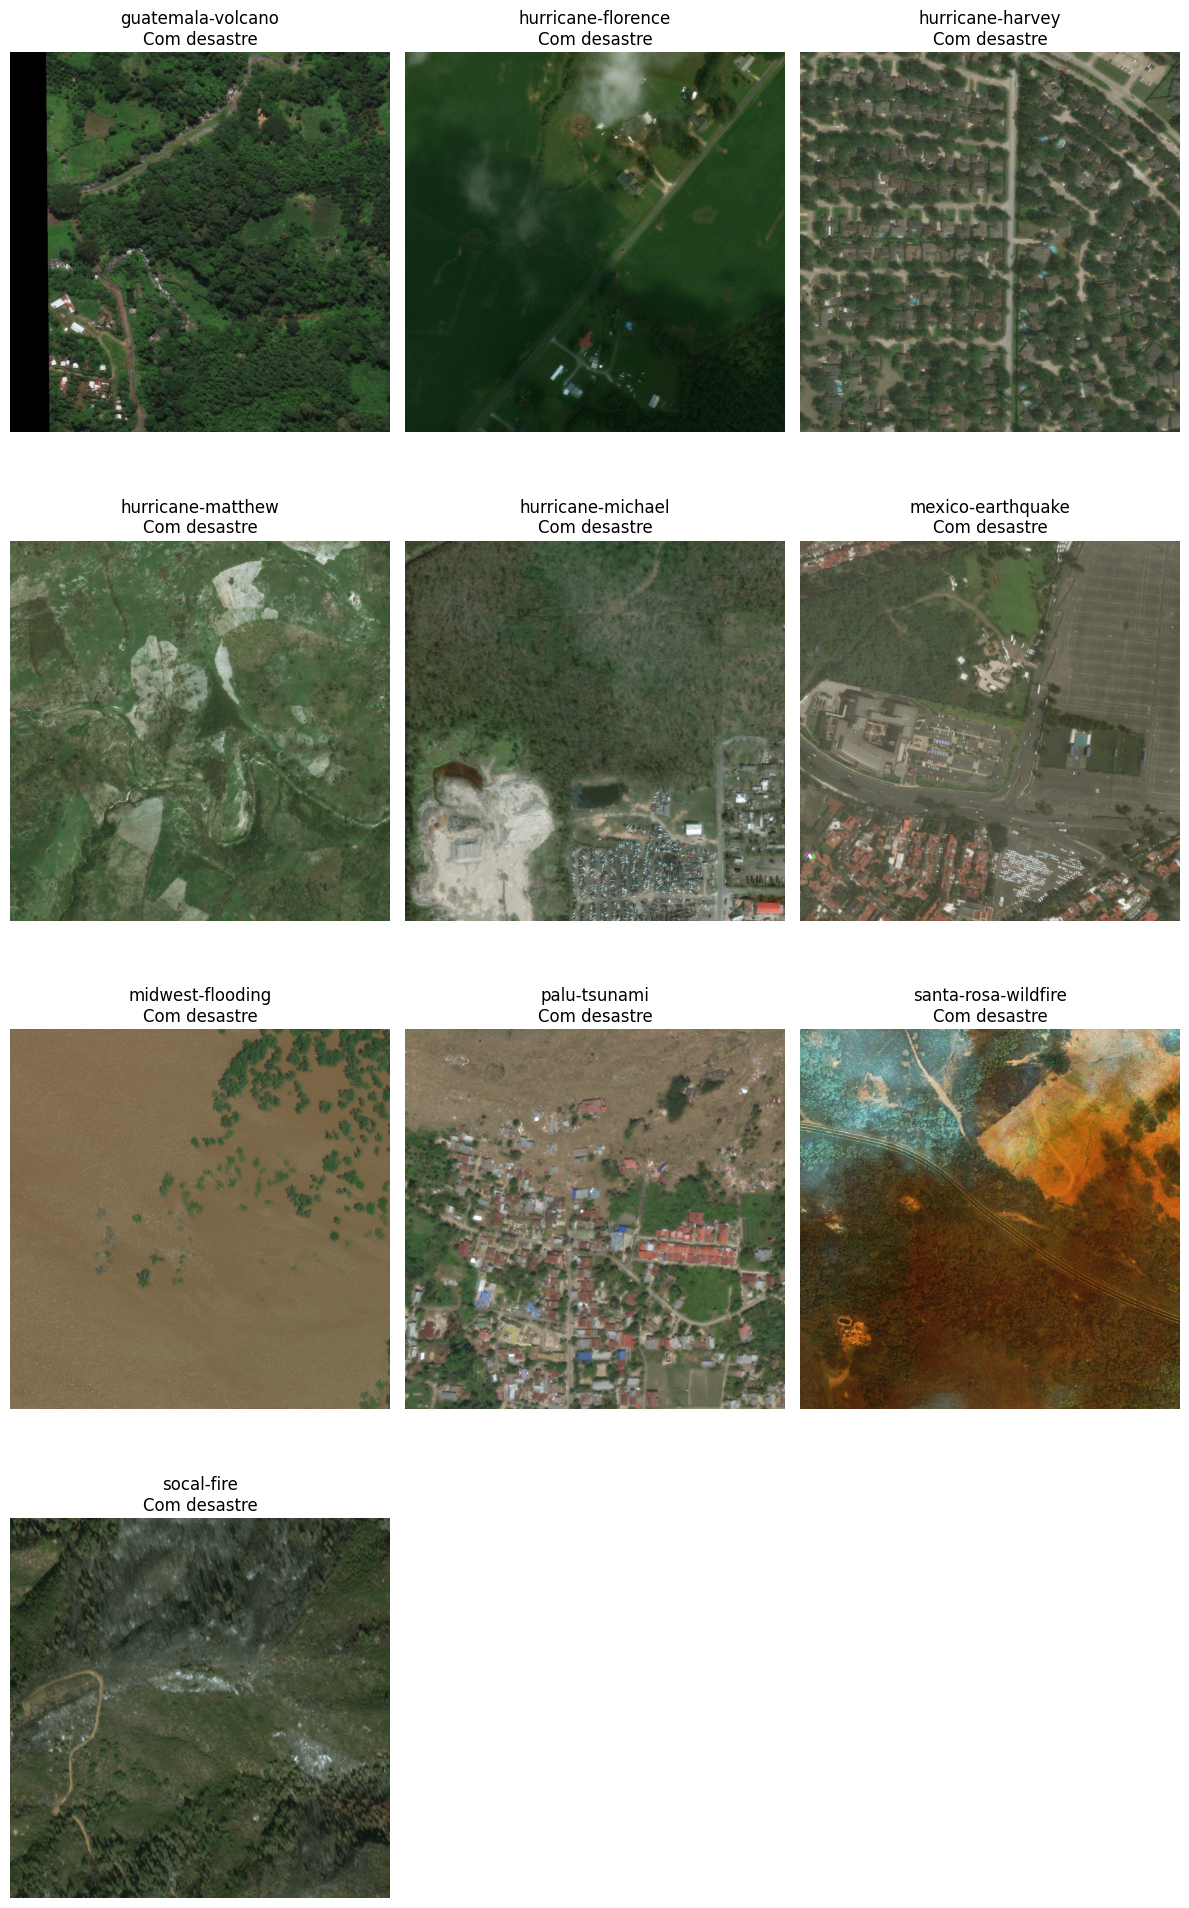

In [14]:
import os
import matplotlib.pyplot as plt
from PIL import Image

def plot_disaster_samples_by_type_in_grid(data, image_dir):
    unique_disaster_types = data['Disaster Type'].unique()
    num_disaster_types = len(unique_disaster_types)
    grid_cols = 3  # Define the number of columns in the grid
    grid_rows = (num_disaster_types + grid_cols - 1) // grid_cols  # Calculate required rows

    plt.figure(figsize=(12, 5 * grid_rows))

    for i, disaster_type in enumerate(unique_disaster_types, 1):
        # Filter data for the specific disaster type
        disaster_subset = data[data['Disaster Type'] == disaster_type]

        if disaster_subset.empty:
            print(f"No images found for disaster type: {disaster_type}")
            continue

        # Randomly sample one image
        sampled_image = disaster_subset.sample(1).iloc[0]
        image_path = os.path.join(image_dir, sampled_image['Image Name'])

        if os.path.exists(image_path):
            img = Image.open(image_path)
            plt.subplot(grid_rows, grid_cols, i)
            plt.imshow(img)
            plt.axis('off')
            plt.title(f"{disaster_type}\n{sampled_image['Disaster Status']}")
        else:
            print(f"Image not found: {image_path}")

    plt.tight_layout()
    plt.show()

# Plot one sample image for each disaster type in a grid
plot_disaster_samples_by_type_in_grid(disasters, IMAGES_PATH)


In [15]:
from PIL import Image
import numpy as np

test_image = os.path.join(IMAGES_PATH, disasters['Image Reference'].iloc[0]) + '.png'
test_image = np.array(Image.open(test_image))
test_image.shape

(1024, 1024, 3)

# DataLoader

In [16]:
# 1. Preparação dos dados
df = image_metadata_df.copy()

# Dropando o vulcão por baixíssmas quantidade de amostras
df = df.drop(df[df['Disaster Type'] == 'guatemala-volcano'].index)

df['Image Path'] = df['Image Name'].apply(lambda x: os.path.join(IMAGES_PATH, x))
df['Label'] = df['Disaster Status'].map({'Com desastre': 1, 'Sem desastre': 0})

In [17]:
# concatenar label com tipo de desastre para termos distribuições
# quanto a essas duas features parecidas no treino e teste
df = df.assign(
    stratify_col = df['Disaster Type'] + '_' + df['Label'].astype(str)
)
df = df.drop(columns='Image Reference')

train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['stratify_col'], random_state=42)
val_df, test_df = train_test_split(val_df, test_size=0.5, stratify=val_df['stratify_col'], random_state=42)

In [18]:
val_df[val_df['Label'] == 1]['Disaster Type'].value_counts()

Disaster Type
socal-fire             82
hurricane-michael      34
hurricane-harvey       32
hurricane-florence     32
midwest-flooding       28
hurricane-matthew      24
santa-rosa-wildfire    23
mexico-earthquake      12
palu-tsunami           11
Name: count, dtype: int64

In [19]:
only_disasters = test_df[test_df['Label'] == 1]
wildfire = only_disasters[only_disasters['Disaster Type'] == 'santa-rosa-wildfire']
flooding = only_disasters[only_disasters['Disaster Type'] == 'midwest-flooding']

## Usar imagens geradas

In [20]:
train_df['Disaster Type'].value_counts()

Disaster Type
socal-fire             1316
hurricane-michael       548
hurricane-harvey        510
hurricane-florence      510
midwest-flooding        446
hurricane-matthew       381
santa-rosa-wildfire     362
mexico-earthquake       194
palu-tsunami            182
Name: count, dtype: int64

In [21]:
import os

flooding_paths = os.listdir('flooding-816')[:100]
wildfire_paths = os.listdir('wildfire-816')[:100]

df_flooding_generated = pd.DataFrame(
    {
        'Image Name': flooding_paths,
        'Disaster Type': 'midwest-flooding',
        'Disaster Status': 'Com desastre',
        'Image Path': ['/teamspace/studios/this_studio/wildfire-816/' + path for path in wildfire_paths],
        'Label': 1,
        'stratify_col': 'midwest-flooding_1'
    }
)

df_wildfire_generated = pd.DataFrame(
    {
        'Image Name': wildfire_paths,
        'Disaster Type': 'santa-rosa-wildfire',
        'Disaster Status': 'Com desastre',
        'Image Path': ['/teamspace/studios/this_studio/flooding-816/' + path for path in flooding_paths],
        'Label': 1,
        'stratify_col': 'santa-rosa-wildfire_1'

    }
)

df_generated = pd.concat([df_flooding_generated, df_wildfire_generated])


In [22]:
train_df_with_gen = pd.concat([train_df, df_generated])

In [23]:
train_df_with_gen['Disaster Type'].value_counts()

Disaster Type
socal-fire             1316
hurricane-michael       548
midwest-flooding        546
hurricane-harvey        510
hurricane-florence      510
santa-rosa-wildfire     462
hurricane-matthew       381
mexico-earthquake       194
palu-tsunami            182
Name: count, dtype: int64

## Classes

In [24]:
class DisasterDataset(Dataset):
    def __init__(self, dataframe, transform=None, return_disaster=False):
        self.dataframe = dataframe
        self.transform = transform
        self.return_disaster = return_disaster

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['Image Path']
        label = self.dataframe.iloc[idx]['Label']
        disaster = self.dataframe.iloc[idx]['Disaster Type']
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        if self.return_disaster:
            return image, torch.tensor(label, dtype=torch.float32), disaster
        else:
            return image, torch.tensor(label, dtype=torch.float32)

In [25]:
# Shape de 1024x1024 para 256x256
IMG_HEIGHT = 512
IMG_WIDTH = 512
# Transformações
data_transforms = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.ToTensor(),  # Converte imagem PIL para tensor e normaliza
])

In [26]:
BATCH_SIZE = 32

# Criar datasets e dataloaders
train_dataset = DisasterDataset(train_df, transform=data_transforms)
val_dataset = DisasterDataset(val_df, transform=data_transforms)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Modelo

In [27]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = self.shortcut(x)
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += residual  # Soma o atalho à saída convolucional
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, num_classes=1):
        super(ResNet, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.layer1 = ResidualBlock(64, 64, stride=1)
        self.layer2 = ResidualBlock(64, 128, stride=2)
        self.layer3 = ResidualBlock(128, 128, stride=2)
        self.layer4 = ResidualBlock(128, 256, stride=2)

        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.global_avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


# Treinamento

In [28]:
import torch
from torch import nn
# torch.backends.nnpack.enabled = False

LEARNING_RATE = 0.0005

# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# Instanciar o modelo
model = ResNet(num_classes=1).to(device)
#model = LeNet().to(device)
print(model)


# altere a função de custo e o otimizador
#loss_fn = nn.CrossEntropyLoss()
#optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

Using cuda device
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (layer1): ResidualBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (shortcut): Sequential()
  )
  (layer2): ResidualBlock(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(128, 128, kernel_size=(3,

In [29]:
from tqdm import tqdm, trange


def train(dataloader, model, loss_fn, optimizer):
    model.train()
    total_loss = 0
    correct = 0
    for X, y in tqdm(dataloader,  desc="Training Epoch", unit="batch"):
        X, y = X.to(device), y.to(device).unsqueeze(1)  # Ajustar dimensões do rótulo
        X = X.to(torch.float32)
        #print(f"X dtype: {X.dtype}, X shape: {X.shape}")
        #print(f"y dtype: {y.dtype}, y shape: {y.shape}")

        # Forward pass
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += ((torch.sigmoid(pred) > 0.5) == y).type(torch.float).sum().item()

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / len(dataloader.dataset)
    return avg_loss, accuracy

# Função de validação
def validate(dataloader, model, loss_fn):
    model.eval()
    total_loss = 0
    correct = 0
    with torch.no_grad():
        for X, y in tqdm(dataloader, desc='Validate Epoch', unit='batchs'):
            X, y = X.to(device), y.to(device).unsqueeze(1)
            pred = model(X)
            loss = loss_fn(pred, y)
            total_loss += loss.item()
            correct += ((torch.sigmoid(pred) > 0.5) == y).type(torch.float).sum().item()

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / len(dataloader.dataset)
    return avg_loss, accuracy

### Executar treino

In [30]:
EPOCHS = 15

os.makedirs('/teamspace/studios/this_studio/checkpoint/', exist_ok=True)

train_loss_hist = []
val_loss_hist = []
train_acc_hist = []
val_acc_hist = []

for epoch in range(EPOCHS):
    train_loss, train_acc = train(train_loader, model, loss_fn, optimizer)
    val_loss, val_acc = validate(val_loader, model, loss_fn)

    train_loss_hist.append(train_loss)
    val_loss_hist.append(val_loss)
    train_acc_hist.append(train_acc)
    val_acc_hist.append(val_acc)

    tqdm.write(f"Epoch {epoch+1}/{EPOCHS}")
    tqdm.write(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    tqdm.write(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")


    checkpoint_path = f"/teamspace/studios/this_studio/checkpoint/checkpoint_epoch_{epoch+1}.pth"
    torch.save({
        'epoch': epoch+1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss_hist': train_loss_hist,
        'val_loss_hist': val_loss_hist,
        'train_acc_hist': train_acc_hist,
        'val_acc_hist': val_acc_hist
    }, checkpoint_path)
    tqdm.write(f"Checkpoint salvo: {checkpoint_path}")

torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, "modelo_e_otimizador.pth")

print("Treinamento concluído!")


Validate Epoch: 100%|██████████| 18/18 [00:18<00:00,  1.05s/batchs]


Epoch 1/15
Train Loss: 0.5956, Train Acc: 0.6694
Val Loss: 0.5802, Val Acc: 0.6996
Checkpoint salvo: /teamspace/studios/this_studio/checkpoint/checkpoint_epoch_1.pth


Validate Epoch: 100%|██████████| 18/18 [00:19<00:00,  1.06s/batchs]


Epoch 2/15
Train Loss: 0.5394, Train Acc: 0.7157
Val Loss: 0.6459, Val Acc: 0.6583
Checkpoint salvo: /teamspace/studios/this_studio/checkpoint/checkpoint_epoch_2.pth


Validate Epoch: 100%|██████████| 18/18 [00:19<00:00,  1.06s/batchs]


Epoch 3/15
Train Loss: 0.5149, Train Acc: 0.7399
Val Loss: 0.5207, Val Acc: 0.7230
Checkpoint salvo: /teamspace/studios/this_studio/checkpoint/checkpoint_epoch_3.pth


Validate Epoch: 100%|██████████| 18/18 [00:19<00:00,  1.06s/batchs]


Epoch 4/15
Train Loss: 0.4657, Train Acc: 0.7712
Val Loss: 0.6214, Val Acc: 0.6817
Checkpoint salvo: /teamspace/studios/this_studio/checkpoint/checkpoint_epoch_4.pth


Validate Epoch: 100%|██████████| 18/18 [00:18<00:00,  1.05s/batchs]


Epoch 5/15
Train Loss: 0.4571, Train Acc: 0.7826
Val Loss: 0.8769, Val Acc: 0.5953
Checkpoint salvo: /teamspace/studios/this_studio/checkpoint/checkpoint_epoch_5.pth


Validate Epoch: 100%|██████████| 18/18 [00:18<00:00,  1.05s/batchs]


Epoch 6/15
Train Loss: 0.4304, Train Acc: 0.7988
Val Loss: 0.5537, Val Acc: 0.6835
Checkpoint salvo: /teamspace/studios/this_studio/checkpoint/checkpoint_epoch_6.pth


Validate Epoch: 100%|██████████| 18/18 [00:18<00:00,  1.04s/batchs]


Epoch 7/15
Train Loss: 0.3903, Train Acc: 0.8256
Val Loss: 0.7960, Val Acc: 0.6529
Checkpoint salvo: /teamspace/studios/this_studio/checkpoint/checkpoint_epoch_7.pth


Validate Epoch: 100%|██████████| 18/18 [00:18<00:00,  1.03s/batchs]


Epoch 8/15
Train Loss: 0.3511, Train Acc: 0.8483
Val Loss: 0.3788, Val Acc: 0.8273
Checkpoint salvo: /teamspace/studios/this_studio/checkpoint/checkpoint_epoch_8.pth


Validate Epoch: 100%|██████████| 18/18 [00:18<00:00,  1.03s/batchs]


Epoch 9/15
Train Loss: 0.3299, Train Acc: 0.8541
Val Loss: 0.8513, Val Acc: 0.7086
Checkpoint salvo: /teamspace/studios/this_studio/checkpoint/checkpoint_epoch_9.pth


Validate Epoch: 100%|██████████| 18/18 [00:18<00:00,  1.04s/batchs]


Epoch 10/15
Train Loss: 0.2985, Train Acc: 0.8710
Val Loss: 1.0237, Val Acc: 0.6187
Checkpoint salvo: /teamspace/studios/this_studio/checkpoint/checkpoint_epoch_10.pth


Validate Epoch: 100%|██████████| 18/18 [00:18<00:00,  1.05s/batchs]


Epoch 11/15
Train Loss: 0.2858, Train Acc: 0.8782
Val Loss: 0.4932, Val Acc: 0.7734
Checkpoint salvo: /teamspace/studios/this_studio/checkpoint/checkpoint_epoch_11.pth


Validate Epoch: 100%|██████████| 18/18 [00:18<00:00,  1.05s/batchs]


Epoch 12/15
Train Loss: 0.2591, Train Acc: 0.8959
Val Loss: 1.0394, Val Acc: 0.6727
Checkpoint salvo: /teamspace/studios/this_studio/checkpoint/checkpoint_epoch_12.pth


Validate Epoch: 100%|██████████| 18/18 [00:18<00:00,  1.04s/batchs]


Epoch 13/15
Train Loss: 0.2416, Train Acc: 0.8998
Val Loss: 1.5310, Val Acc: 0.6151
Checkpoint salvo: /teamspace/studios/this_studio/checkpoint/checkpoint_epoch_13.pth


Validate Epoch: 100%|██████████| 18/18 [00:18<00:00,  1.05s/batchs]


Epoch 14/15
Train Loss: 0.2337, Train Acc: 0.9094
Val Loss: 0.6158, Val Acc: 0.7392
Checkpoint salvo: /teamspace/studios/this_studio/checkpoint/checkpoint_epoch_14.pth


Validate Epoch: 100%|██████████| 18/18 [00:18<00:00,  1.05s/batchs]

Epoch 15/15
Train Loss: 0.2038, Train Acc: 0.9218
Val Loss: 0.5216, Val Acc: 0.8165
Checkpoint salvo: /teamspace/studios/this_studio/checkpoint/checkpoint_epoch_15.pth
Treinamento concluído!


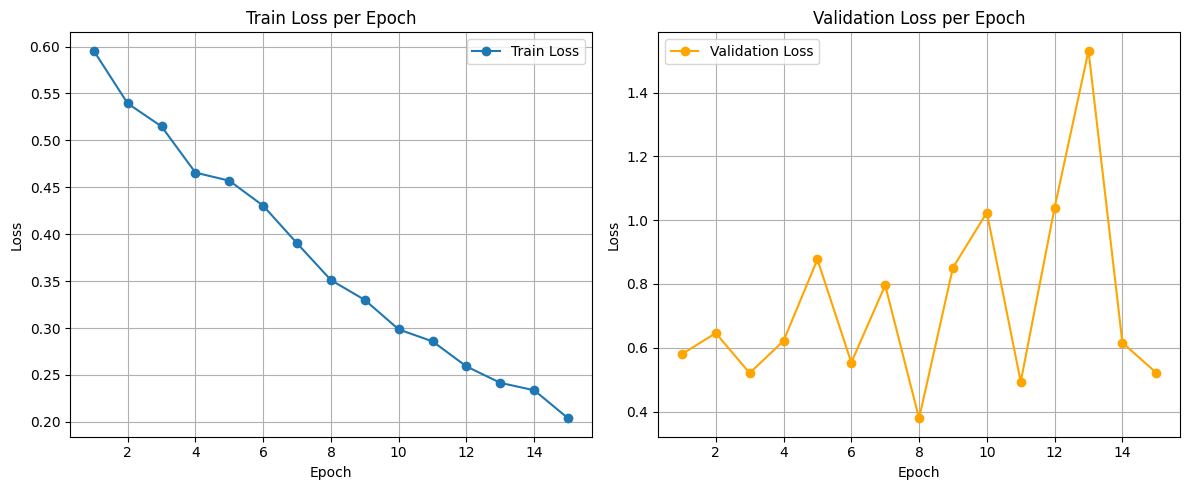

In [36]:
import matplotlib.pyplot as plt

# Configurar o plot
fig, ax = plt.subplots(1, 2, figsize=(12, 5))  # 1 linha, 2 colunas

# Plot do treinamento
ax[0].plot(range(1, 15 + 1), train_loss_hist, marker='o', label='Train Loss')
ax[0].set_title('Train Loss per Epoch')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[0].grid(True)

# Plot da validação
ax[1].plot(range(1, 15 + 1), val_loss_hist, marker='o', label='Validation Loss', color='orange')
ax[1].set_title('Validation Loss per Epoch')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()
ax[1].grid(True)

# Ajustar espaçamento e mostrar
plt.tight_layout()
plt.show()

## Carrega modelo (se existir)

In [37]:
if os.path.exists("modelo_e_otimizador.pth"):
    checkpoint = torch.load("modelo_e_otimizador.pth")
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

## Teste

In [38]:
BATCH_SIZE = 32

test_dataset = DisasterDataset(val_df, transform=data_transforms, return_disaster=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [34]:
def test_pred(model, test_loader, device):
    """
    Função de teste para o modelo.
    Retorna predições, rótulos reais e tipos de desastre.
    """
    model.eval()
    all_preds = []
    all_labels = []
    all_disaster_types = []

    with torch.no_grad():
        for inputs, labels, disaster_types in tqdm(test_loader, desc='Test Loader', unit='batch'):
            # Preparar os dados
            inputs = inputs.to(device).to(torch.float32)
            labels = labels.to(device).unsqueeze(1)  # Ajuste dimensional
            disaster_types = np.array(disaster_types)  # Converter tipos de desastre para array

            # Fazer predições
            outputs = model(inputs)
            preds = (torch.sigmoid(outputs) > 0.5).cpu().numpy()  # Predições binárias

            # Armazenar resultados
            all_preds.extend(preds.flatten())  # Garantir formato correto
            all_labels.extend(labels.cpu().numpy().flatten())
            all_disaster_types.extend(disaster_types)

    return all_preds, all_labels, all_disaster_types

Test Loader: 100%|██████████| 18/18 [00:19<00:00,  1.06s/batch]


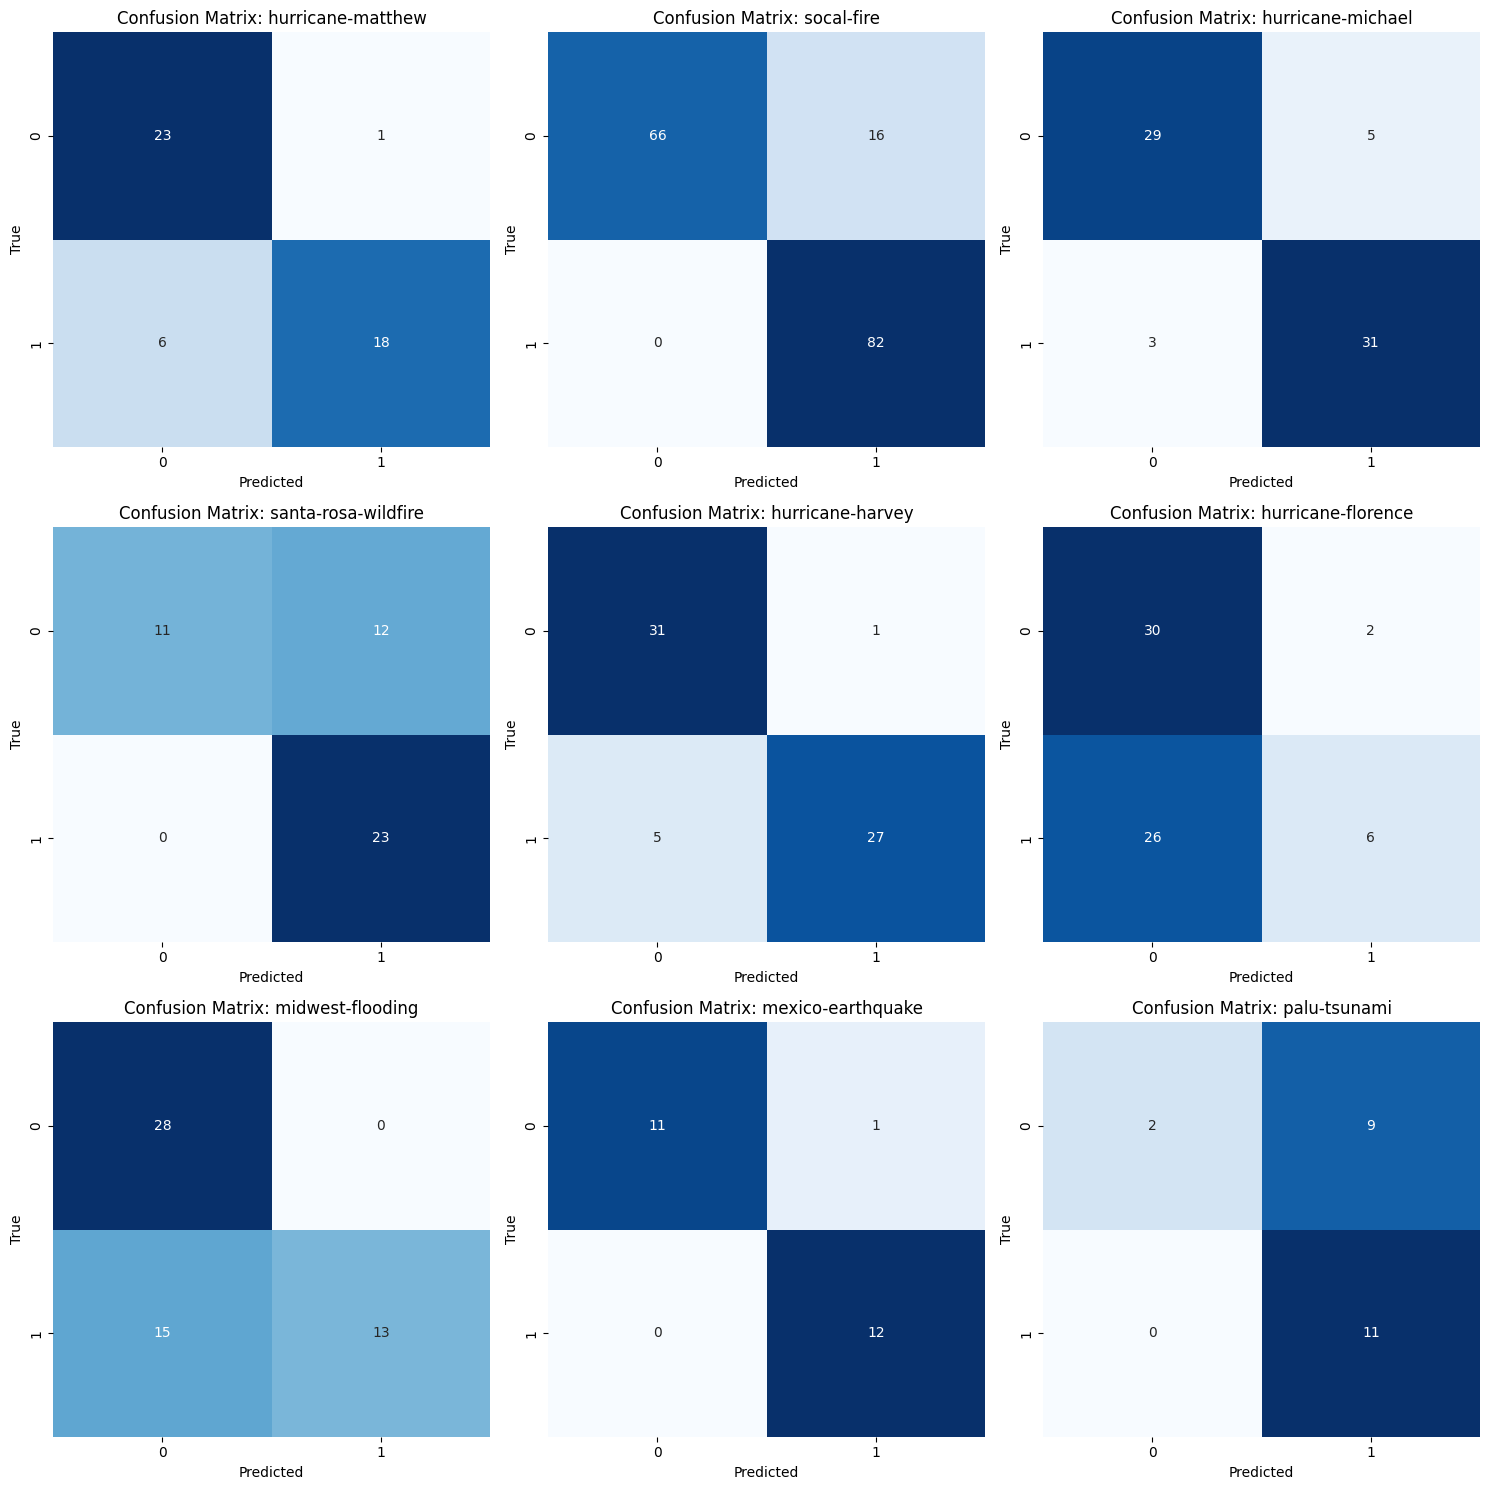

In [39]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Rodar a função de teste
all_test_preds, all_test_labels, all_test_disaster = test_pred(model, test_loader, device)

# Organizar os resultados em DataFrame
results_df = pd.DataFrame({
    "true_label": all_test_labels,
    "predicted_label": all_test_preds,
    "disaster_type": all_test_disaster
})

# Obter os tipos únicos de desastre
disaster_types = results_df["disaster_type"].unique()

# Configurar o grid
num_disasters = len(disaster_types)
cols = 3  # Número de colunas no grid
rows = (num_disasters + cols - 1) // cols  # Calcula o número de linhas necessário

fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
axes = axes.flatten()  # Achata os eixos para fácil iteração

# Iterar sobre cada tipo de desastre e criar a matriz de confusão
for i, disaster in enumerate(disaster_types):
    # Filtrar os dados para o tipo de desastre atual
    subset = results_df[results_df["disaster_type"] == disaster]
    
    # Calcular a matriz de confusão
    cm = confusion_matrix(subset["true_label"], subset["predicted_label"])
    
    # Plotar a matriz de confusão no subplot
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i], cbar=False)
    axes[i].set_title(f"Confusion Matrix: {disaster}")
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("True")

# Desativar subplots vazios, caso o número de desastres não preencha o grid
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Ajustar o layout
plt.tight_layout()
plt.show()

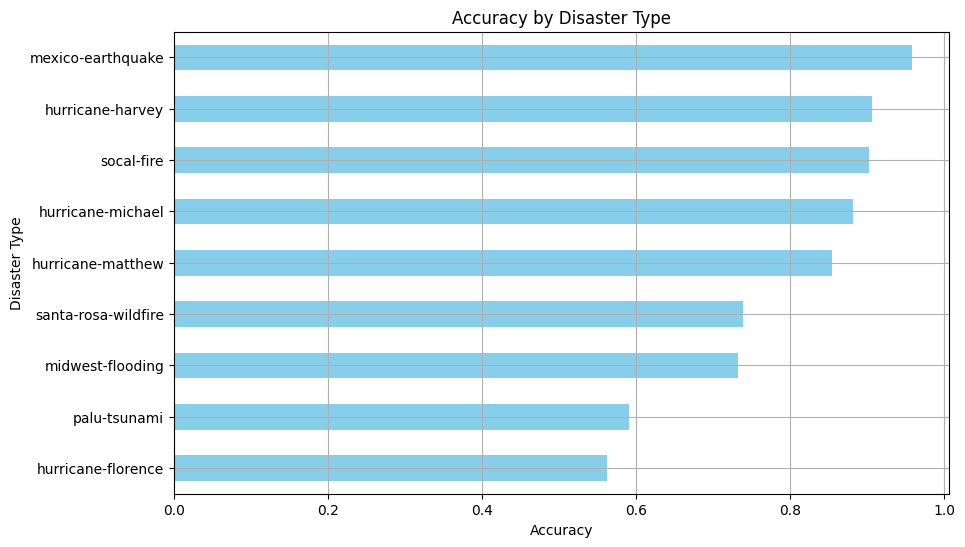

In [40]:
import matplotlib.pyplot as plt

# Calcular acurácia por tipo de desastre
accuracy_by_disaster = results_df.groupby("disaster_type").apply(
    lambda x: (x["true_label"] == x["predicted_label"]).mean()
)

# Plotar
accuracy_by_disaster.sort_values().plot(kind="barh", figsize=(10, 6), color="skyblue")
plt.xlabel("Accuracy")
plt.ylabel("Disaster Type")
plt.title("Accuracy by Disaster Type")
plt.grid(True)
plt.show()


In [41]:
print(f'Acurácia geral:{(results_df["predicted_label"] == results_df["true_label"]).sum()/len(results_df):.2f}')

Acurácia geral:0.82


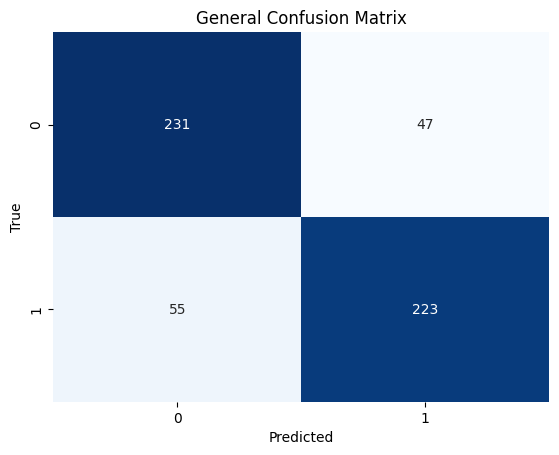

In [43]:
cm = confusion_matrix(results_df["true_label"], results_df["predicted_label"])

# Plotar a matriz de confusão no subplot
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f"General Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()